In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
from inference.spatial_compartmental.viz import  posterior_comparison, post_prediction_comparison
import jax
jax.config.update("jax_enable_x64", True) #64 bit precision calcs
jax.config.update('jax_platform_name', 'cpu')
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from abm.spatial_compartmental.si import get_abm
from abm.spatial_compartmental.utils import Neighbourhood, calc_start_n_initial
import pickle

/home/tim/Documents/thesis/aims_dgs4abm/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(f"JAX devices: {jax.devices()}")

JAX devices: [CpuDevice(id=0)]


In [3]:
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

def get_color_by_label(ax, label):
    """
    Finds a plotted element on the axes by its label and returns its color.

    Args:
        ax (matplotlib.axes.Axes): The axes object containing the plot.
        label (str): The label of the element to find.

    Returns:
        tuple or str or None: The color (often RGBA tuple) of the element,
                               or None if no element with that label is found.
    """
    # Check lines (plot)
    for line in ax.lines:
        if line.get_label() == label:
            return line.get_color() # Returns color format used (e.g., 'red', '#FF0000', (1,0,0,1))

    # Check containers (common for bar plots)
    for container in ax.containers:
        if isinstance(container, BarContainer) and container.get_label() == label:
            # Get color from the first patch in the container
            if container.patches:
                return container.patches[0].get_facecolor() # Returns RGBA tuple

    # Check collections (scatter)
    for collection in ax.collections:
        if collection.get_label() == label:
            # Facecolor is often an array, even for single color. Take the first.
            colors = collection.get_facecolor()
            if colors.size > 0:
                return colors[0] # Returns RGBA tuple array, take first row
            else: # May happen if color is 'none' or similar
                 edge_colors = collection.get_edgecolor()
                 if edge_colors.size > 0:
                     return edge_colors[0]


    # Check individual patches (less common for labeled elements but possible)
    for patch in ax.patches:
         # Only consider patches that are direct children (not part of a container already checked)
        if isinstance(patch, Rectangle) and patch.get_label() == label:
             # Check if it belongs to a container; if so, we likely handled it above
             if patch.get_container() is None or patch.get_container().get_label() != label:
                  return patch.get_facecolor()

    # Label not found
    print(f"Warning: No element found with label '{label}'")
    return None

In [4]:
#NOTE: Requires 64-bit precision
def calculate_NLPD(key, abm_conf, posterior, n_subsample,grid_size, num_steps):
    key, subkey = jax.random.split(key)

    data_for_kde = jax.random.choice(
    subkey,
    posterior[abm_conf]['obs'],
    (n_subsample,)).astype(jnp.float64).T

    key, subkey = jax.random.split(key)

    data_for_kde += 1e-6*jax.random.normal(subkey, (num_steps,n_subsample)) #Add jitter


    kde_est =jax.scipy.stats.gaussian_kde(data_for_kde)

    abm = get_abm(Neighbourhood.DIAGONAL, vmap=True)
    ground_truth_observations = abm(jax.random.split(key,n_subsample), 
                                grid_size, num_steps,abm_conf[0],
                                calc_start_n_initial(abm_conf[1],grid_size))[-1][:,:-1]
    
    log_densities = kde_est.logpdf(ground_truth_observations.astype(jnp.float64).T)
    averaged_nlpd = -np.mean(log_densities)
    if jnp.isnan(averaged_nlpd).any():
        raise ValueError(f'NLPD for {abm_conf} contains NaNs')
    return averaged_nlpd


def calculate_metrics(abm_posterior, surrogates_posterior, grid_size, num_steps, n_subsample=1000):
    metrics_dict = {}

    # ESS per sec
    abm_ess_per_sec = jnp.array([abm_posterior[abm_conf]['mcmc_summary'][0]['n_eff']/abm_posterior[abm_conf]['mcmc_time'] for abm_conf in abm_posterior.keys()])
    metrics_dict['ESS_per_sec'] = {'abm':abm_ess_per_sec}

    for surrogate_name in surrogates_posterior.keys():
        surrogate_ess_per_sec = jnp.array([surrogates_posterior[surrogate_name][abm_conf]['mcmc_summary'][0]['n_eff']/surrogates_posterior[surrogate_name][abm_conf]['mcmc_time'] for abm_conf in abm_posterior.keys()])
        metrics_dict['ESS_per_sec'][surrogate_name]=surrogate_ess_per_sec

    #Posterior Means 
    abm_post_means = jnp.array([jnp.mean(abm_posterior[abm_conf]['posterior_samples']['p_infect']) for abm_conf in abm_posterior.keys()])
    metrics_dict['posterior_mean']={'abm':abm_post_means}
    for surrogate_name in surrogates_posterior.keys():
        surogate_post_means = jnp.array([jnp.mean(surrogates_posterior[surrogate_name][abm_conf]['posterior_samples']['p_infect']) for abm_conf in abm_posterior.keys()])
        metrics_dict['posterior_mean'][surrogate_name]=surogate_post_means
    
    
    #1-Wassersteins
    sorted_abm_dists = jnp.array([sorted(jax.random.choice(jax.random.fold_in(jax.random.PRNGKey(0), idx),
                                                       abm_posterior[abm_conf]['posterior_samples']['p_infect'],
                                                       (n_subsample,))) for idx,abm_conf in enumerate(abm_posterior.keys())])
    
    metrics_dict['1_wasserstein']={}
    for surrogate_name in surrogates_posterior.keys():
        sorted_surogate_dists = jnp.array([sorted(jax.random.choice(jax.random.fold_in(jax.random.PRNGKey(2),idx), 
                                                         surrogates_posterior[surrogate_name][abm_conf]['posterior_samples']['p_infect'],
                                                         (n_subsample,))) for idx,abm_conf in enumerate(abm_posterior.keys())])
        surrogate_1_wassersteins = 1/n_subsample * jnp.sum(jnp.abs(sorted_abm_dists-sorted_surogate_dists),axis=1)
        metrics_dict['1_wasserstein'][surrogate_name]=surrogate_1_wassersteins
        

    #NLPDs
    metrics_dict['NLPD']={}
    abm_nlpds = jnp.array([calculate_NLPD(jax.random.fold_in(jax.random.PRNGKey(0), idx),abm_conf, abm_posterior, 
                                          n_subsample, grid_size, num_steps)  for idx, abm_conf  in enumerate(abm_posterior.keys())])
    metrics_dict['NLPD']={'abm':abm_nlpds}

    for surrogate_name in surrogates_posterior.keys():    

        surrogate_nlpds = jnp.array([calculate_NLPD(jax.random.fold_in(jax.random.PRNGKey(2), idx),abm_conf, surrogates_posterior[surrogate_name], 
                                          n_subsample, grid_size, num_steps)  for idx, abm_conf  in enumerate(abm_posterior.keys())])
        metrics_dict['NLPD'][surrogate_name]=surrogate_nlpds

    return metrics_dict



## Metrics Calculation

In [6]:
g40_s10_output_dir = "inference_outputs/2025-06-01/18-38-13/"

with open(f"{g40_s10_output_dir}/prior_predictions.npy", "rb") as f:
    prior_predictions = jnp.load(f, allow_pickle=True).item()
with open(f"{g40_s10_output_dir}/abm_posterior.npy", "rb") as f:
    abm_posterior = jnp.load(f, allow_pickle=True).item()
with open(f"{g40_s10_output_dir}/surrogates_posterior.npy", "rb") as f:
    surrogates_posterior = jnp.load(f, allow_pickle=True).item()
with open(f"{g40_s10_output_dir}/data.npy", "rb") as f:
    data = jnp.load(f, allow_pickle=True).item()



In [7]:
priorcvae_var_metrics  = calculate_metrics(abm_posterior, surrogates_posterior, grid_size=40, num_steps=10, n_subsample=1000)

In [8]:
with open('../06_02_viz/priorcvae_var_metrics.pkl','wb') as f:
    pickle.dump(priorcvae_var_metrics,f)

In [13]:
with open('../04_24_viz/g40_s10_metrics.pkl','rb') as f:
    prev_metrics = pickle.load(f)

### Posterior Means MSE

In [16]:
print('vae var 2: ', jnp.mean(jnp.square(priorcvae_var_metrics['posterior_mean']['priorcvae_vae_var_2'] - priorcvae_var_metrics['posterior_mean']['abm'])))
print('vae var 5: ', jnp.mean(jnp.square(priorcvae_var_metrics['posterior_mean']['priorcvae_vae_var_5'] - priorcvae_var_metrics['posterior_mean']['abm'])))
print('vae var 10: ', jnp.mean(jnp.square(priorcvae_var_metrics['posterior_mean']['priorcvae_vae_var_10'] - priorcvae_var_metrics['posterior_mean']['abm'])))

vae var 2:  0.18723631
vae var 5:  0.1902496
vae var 10:  0.18878135


### 1-Wassersteins

In [18]:
print(f"vae var 2: {jnp.mean(priorcvae_var_metrics['1_wasserstein']['priorcvae_vae_var_2']):.3f}")
print(f"vae var 5: {jnp.mean(priorcvae_var_metrics['1_wasserstein']['priorcvae_vae_var_5']):.3f}")
print(f"vae var 10: {jnp.mean(priorcvae_var_metrics['1_wasserstein']['priorcvae_vae_var_10']):.3f}")

vae var 2: 0.378
vae var 5: 0.380
vae var 10: 0.379


### NLPDS

In [15]:
print('vae var 2 NLPDs at least as low: ', jnp.sum(priorcvae_var_metrics['NLPD']['priorcvae_vae_var_2']<=priorcvae_var_metrics["NLPD"]['abm']))
print('vae var 5 NLPDs at least as low: ', jnp.sum(priorcvae_var_metrics['NLPD']['priorcvae_vae_var_5']<=priorcvae_var_metrics["NLPD"]['abm']))
print('vae var 10 NLPDs at least as low: ', jnp.sum(priorcvae_var_metrics['NLPD']['priorcvae_vae_var_10']<=priorcvae_var_metrics["NLPD"]['abm']))

vae var 2 NLPDs at least as low:  4
vae var 5 NLPDs at least as low:  4
vae var 10 NLPDs at least as low:  4


## Posterior Plot

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_49064/911146403.py:26: SyntaxWarning: invalid escape sequence '\s'
  ['$\sigma^{2}_{{\mathrm{{vae}}}}=2$', '$\sigma^{2}_{{\mathrm{{vae}}}}=5$', '$\sigma^{2}_{{\mathrm{{vae}}}}=10$'])])
/tmp/ipykernel_49064/911146403.py:26: SyntaxWarning: invalid escape sequence '\s'
  ['

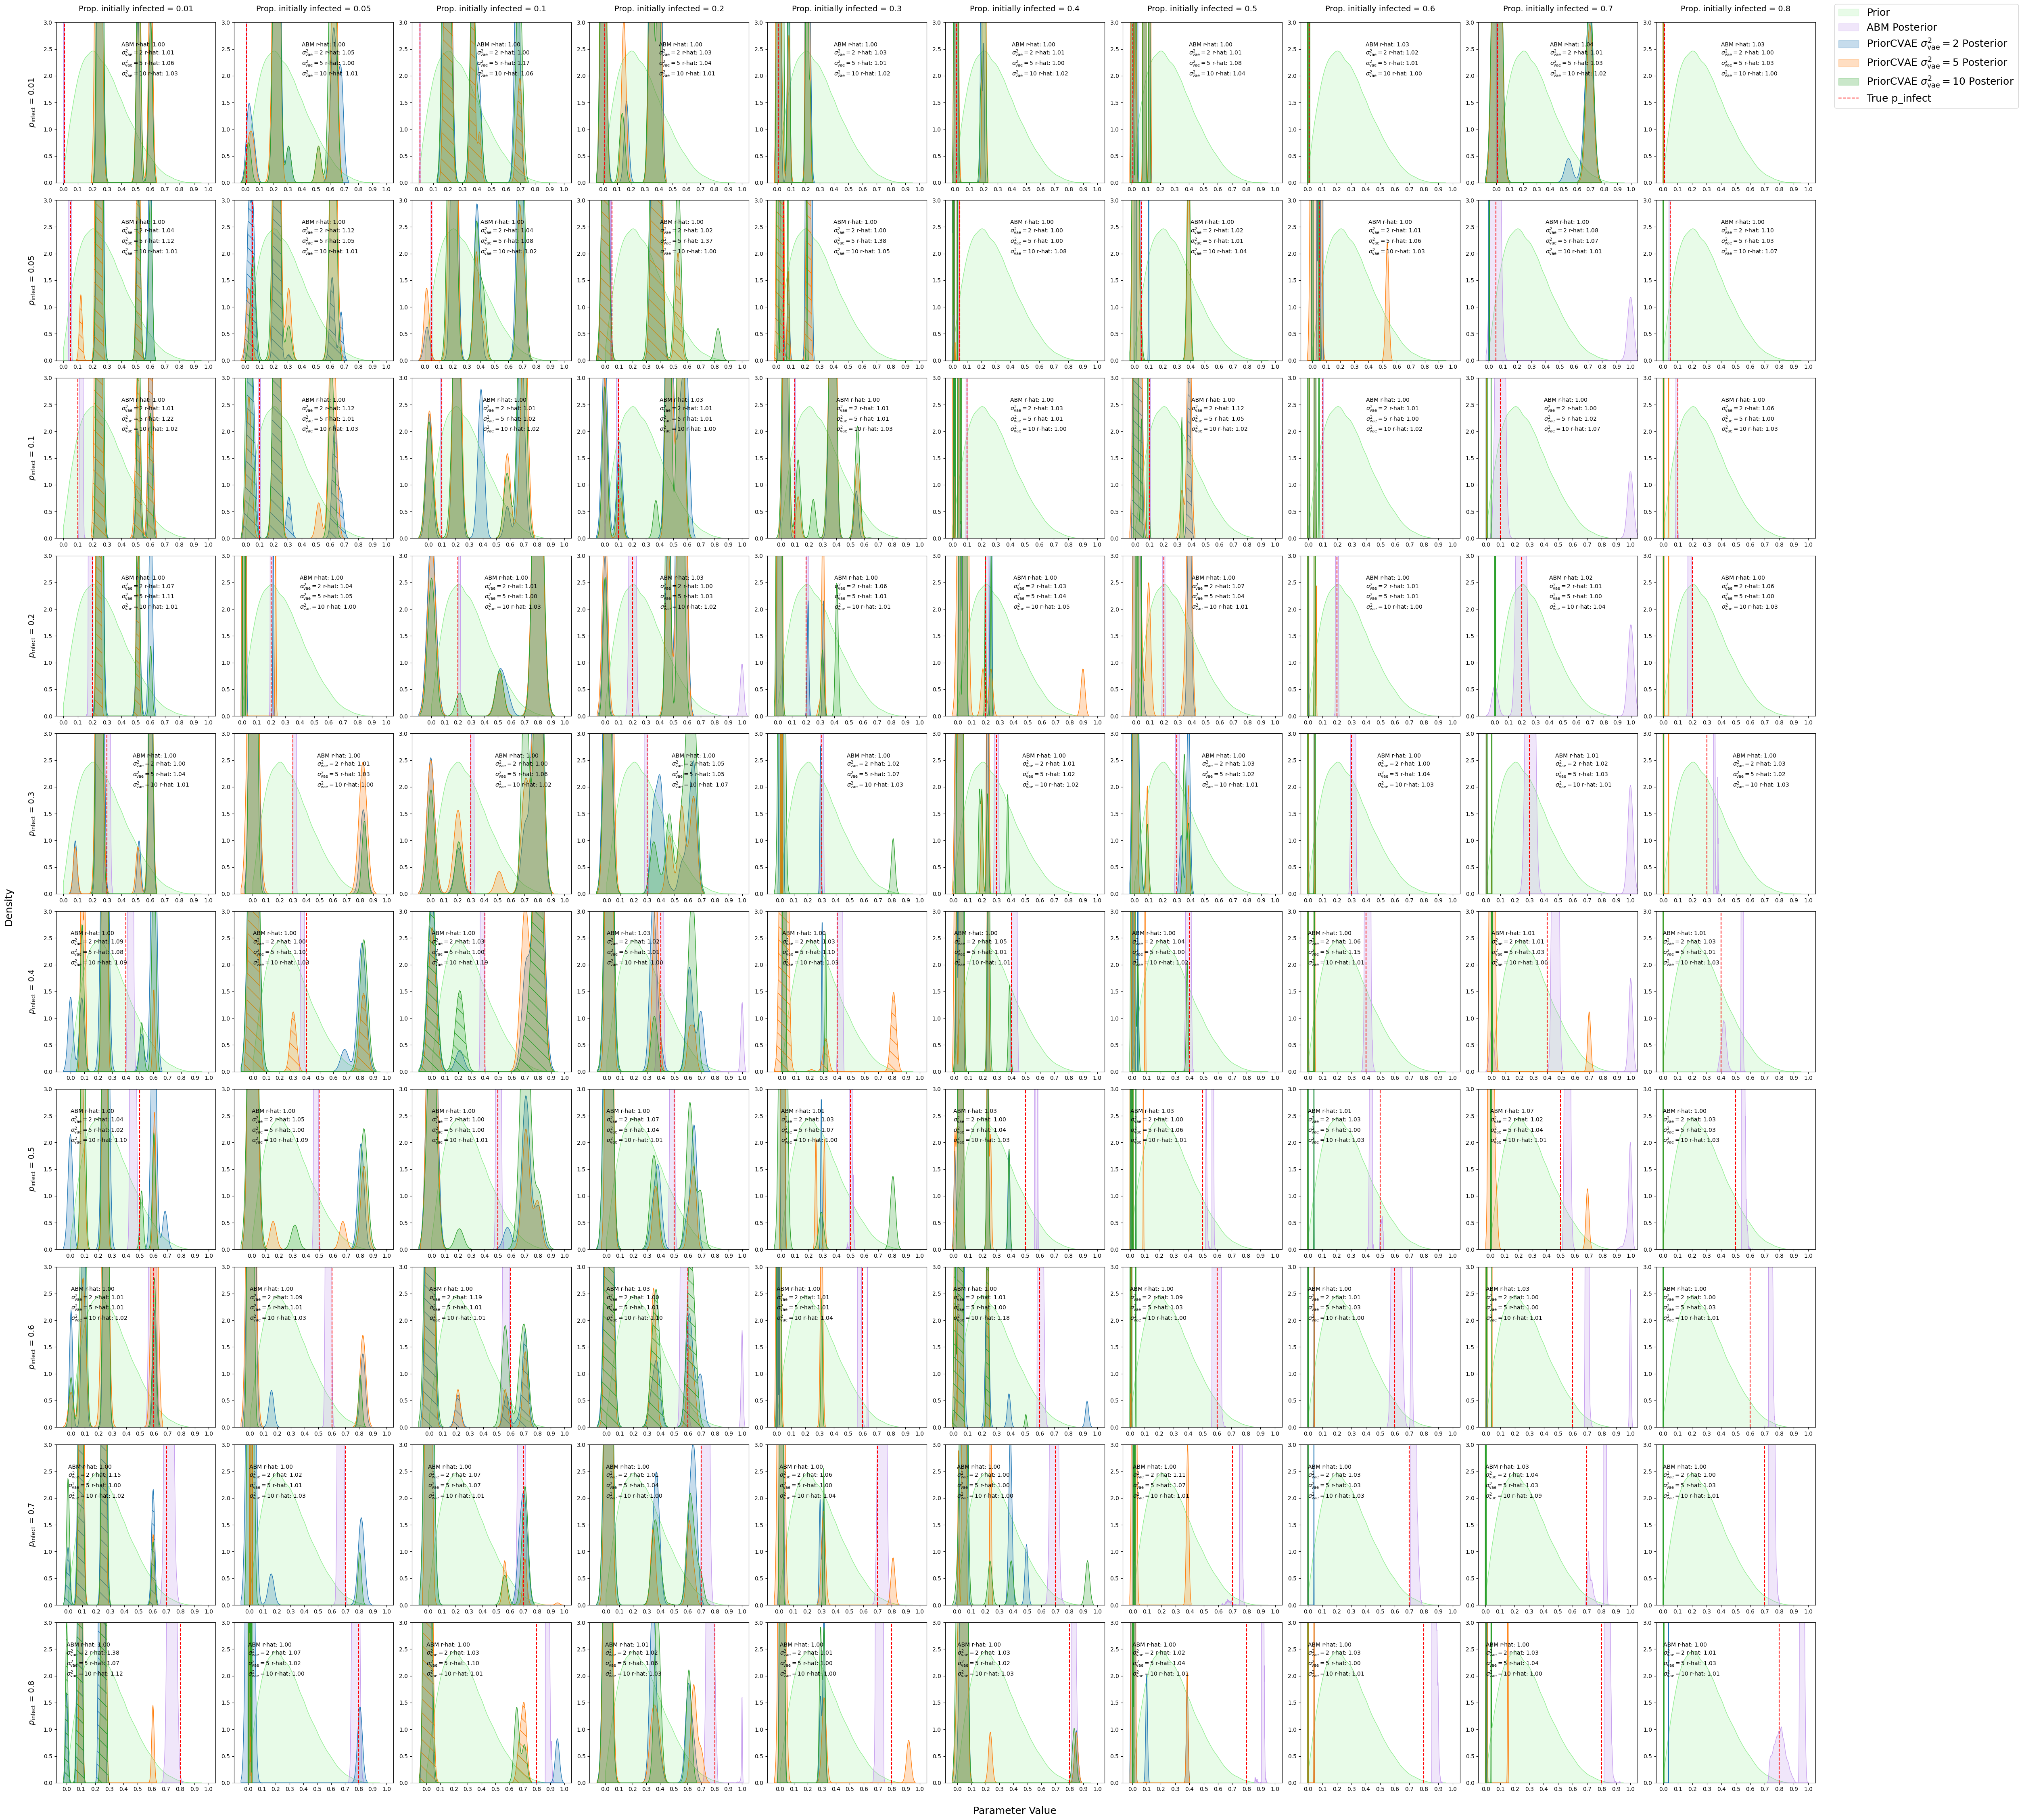

In [27]:
fig, axarr = plt.subplots(10,10,figsize=(50, 45))

for row,p_inf in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    for col,prop_init_infected in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
        rhats={'abm':abm_posterior[(p_inf, prop_init_infected)]["mcmc_summary"][0]['r_hat'],
                'priorcvae_vae_var_2':surrogates_posterior['priorcvae_vae_var_2'][(p_inf, prop_init_infected)]["mcmc_summary"][0]['r_hat'],
                'priorcvae_vae_var_5':surrogates_posterior['priorcvae_vae_var_5'][(p_inf, prop_init_infected)]["mcmc_summary"][0]['r_hat'],
                'priorcvae_vae_var_10':surrogates_posterior['priorcvae_vae_var_10'][(p_inf, prop_init_infected)]["mcmc_summary"][0]['r_hat'],
                }
        axarr[row,col] = posterior_comparison(
                axarr[row,col],
                (p_inf, prop_init_infected),
                abm_posterior,
                surrogates_posterior,
                (p_inf, "p_infect"),
                rhats,
                prior_predictions,
                xlim=(None, 1.05),
                ylim=(0, 3),
                logdensities=False,
                show_legend=False,
                set_x_and_ylabels=False,
            )
        
        surrogate_r_hat_string = '\n'.join([f"{disp_name} r-hat: {rhats[surrogate_name]:.2f}" for surrogate_name,disp_name in zip(['priorcvae_vae_var_2', 'priorcvae_vae_var_5', 'priorcvae_vae_var_10'], 
                                                                                                                                               ['$\sigma^{2}_{{\mathrm{{vae}}}}=2$', '$\sigma^{2}_{{\mathrm{{vae}}}}=5$', '$\sigma^{2}_{{\mathrm{{vae}}}}=10$'])])
        if row<=3:
            text_x=0.4
        elif row==4:
            text_x=0.48
        else:
            text_x=0.00
        axarr[row,col].annotate(
            f"ABM r-hat: {rhats['abm']:.2f}\n"+surrogate_r_hat_string,
            (text_x,2.0),
            )
        axarr[row,col].set_xticks(jnp.arange(0.0, 1.1, 0.1)) 
        #axarr[row,col].set_xticks(jnp.arange(0.0,1.1,0.1),jnp.arange(0.0,1.1,0.1))


legend_handles=[]
for color in [get_color_by_label(axarr[0,0],'Prior'), 
            get_color_by_label(axarr[0,0],'ABM Posterior'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_2 Posterior'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_5 Posterior'),
                  get_color_by_label(axarr[0,0],'priorcvae_vae_var_10 Posterior')]:
    legend_handle=mpatches.Patch(color=color)
    legend_handles.append(legend_handle)
legend_handles.append(Line2D([0],[0],color='red', linestyle='--'))

for idx,p_infect in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    axarr[idx, 0].set_ylabel(f'$p_{{\mathrm{{infect}}}}$ = {p_infect}', rotation=90, labelpad=20, va='center',fontsize=14)

for jdx, initial_infected in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    axarr[0,jdx].set_xlabel(f"Prop. initially infected = {initial_infected}",labelpad=20,fontsize=14)
    axarr[0, jdx].xaxis.set_label_position('top') 

fig.legend(handles=legend_handles, labels=['Prior', 'ABM Posterior', 'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=2$ Posterior',
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=5$ Posterior',
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=10$ Posterior',
                                           'True p_infect'],
           loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure,fontsize=18)
fig.supylabel('Density',fontsize=18,x=-0.001)
fig.supxlabel('Parameter Value',fontsize=18,y=-0.001)
# # fig.suptitle('Comparison of ABM and surrogate posteriors across 100 combinations of prob_infect and initial_infected\nGrid Size 40 and Number of Steps 10', 
# #              y=1.01,fontsize=20)
plt.tight_layout(rect=[0, 0, 0.90, 1],h_pad=1,w_pad=1)
fig.savefig('../06_02_viz/priorcvae_vae_vars_posteriors.pdf',bbox_inches='tight')

# plt.show()

## Predictive Plot

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\s'
<>:70: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:72: SyntaxWarning: invalid escape sequence '\s'
<>:73: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid e

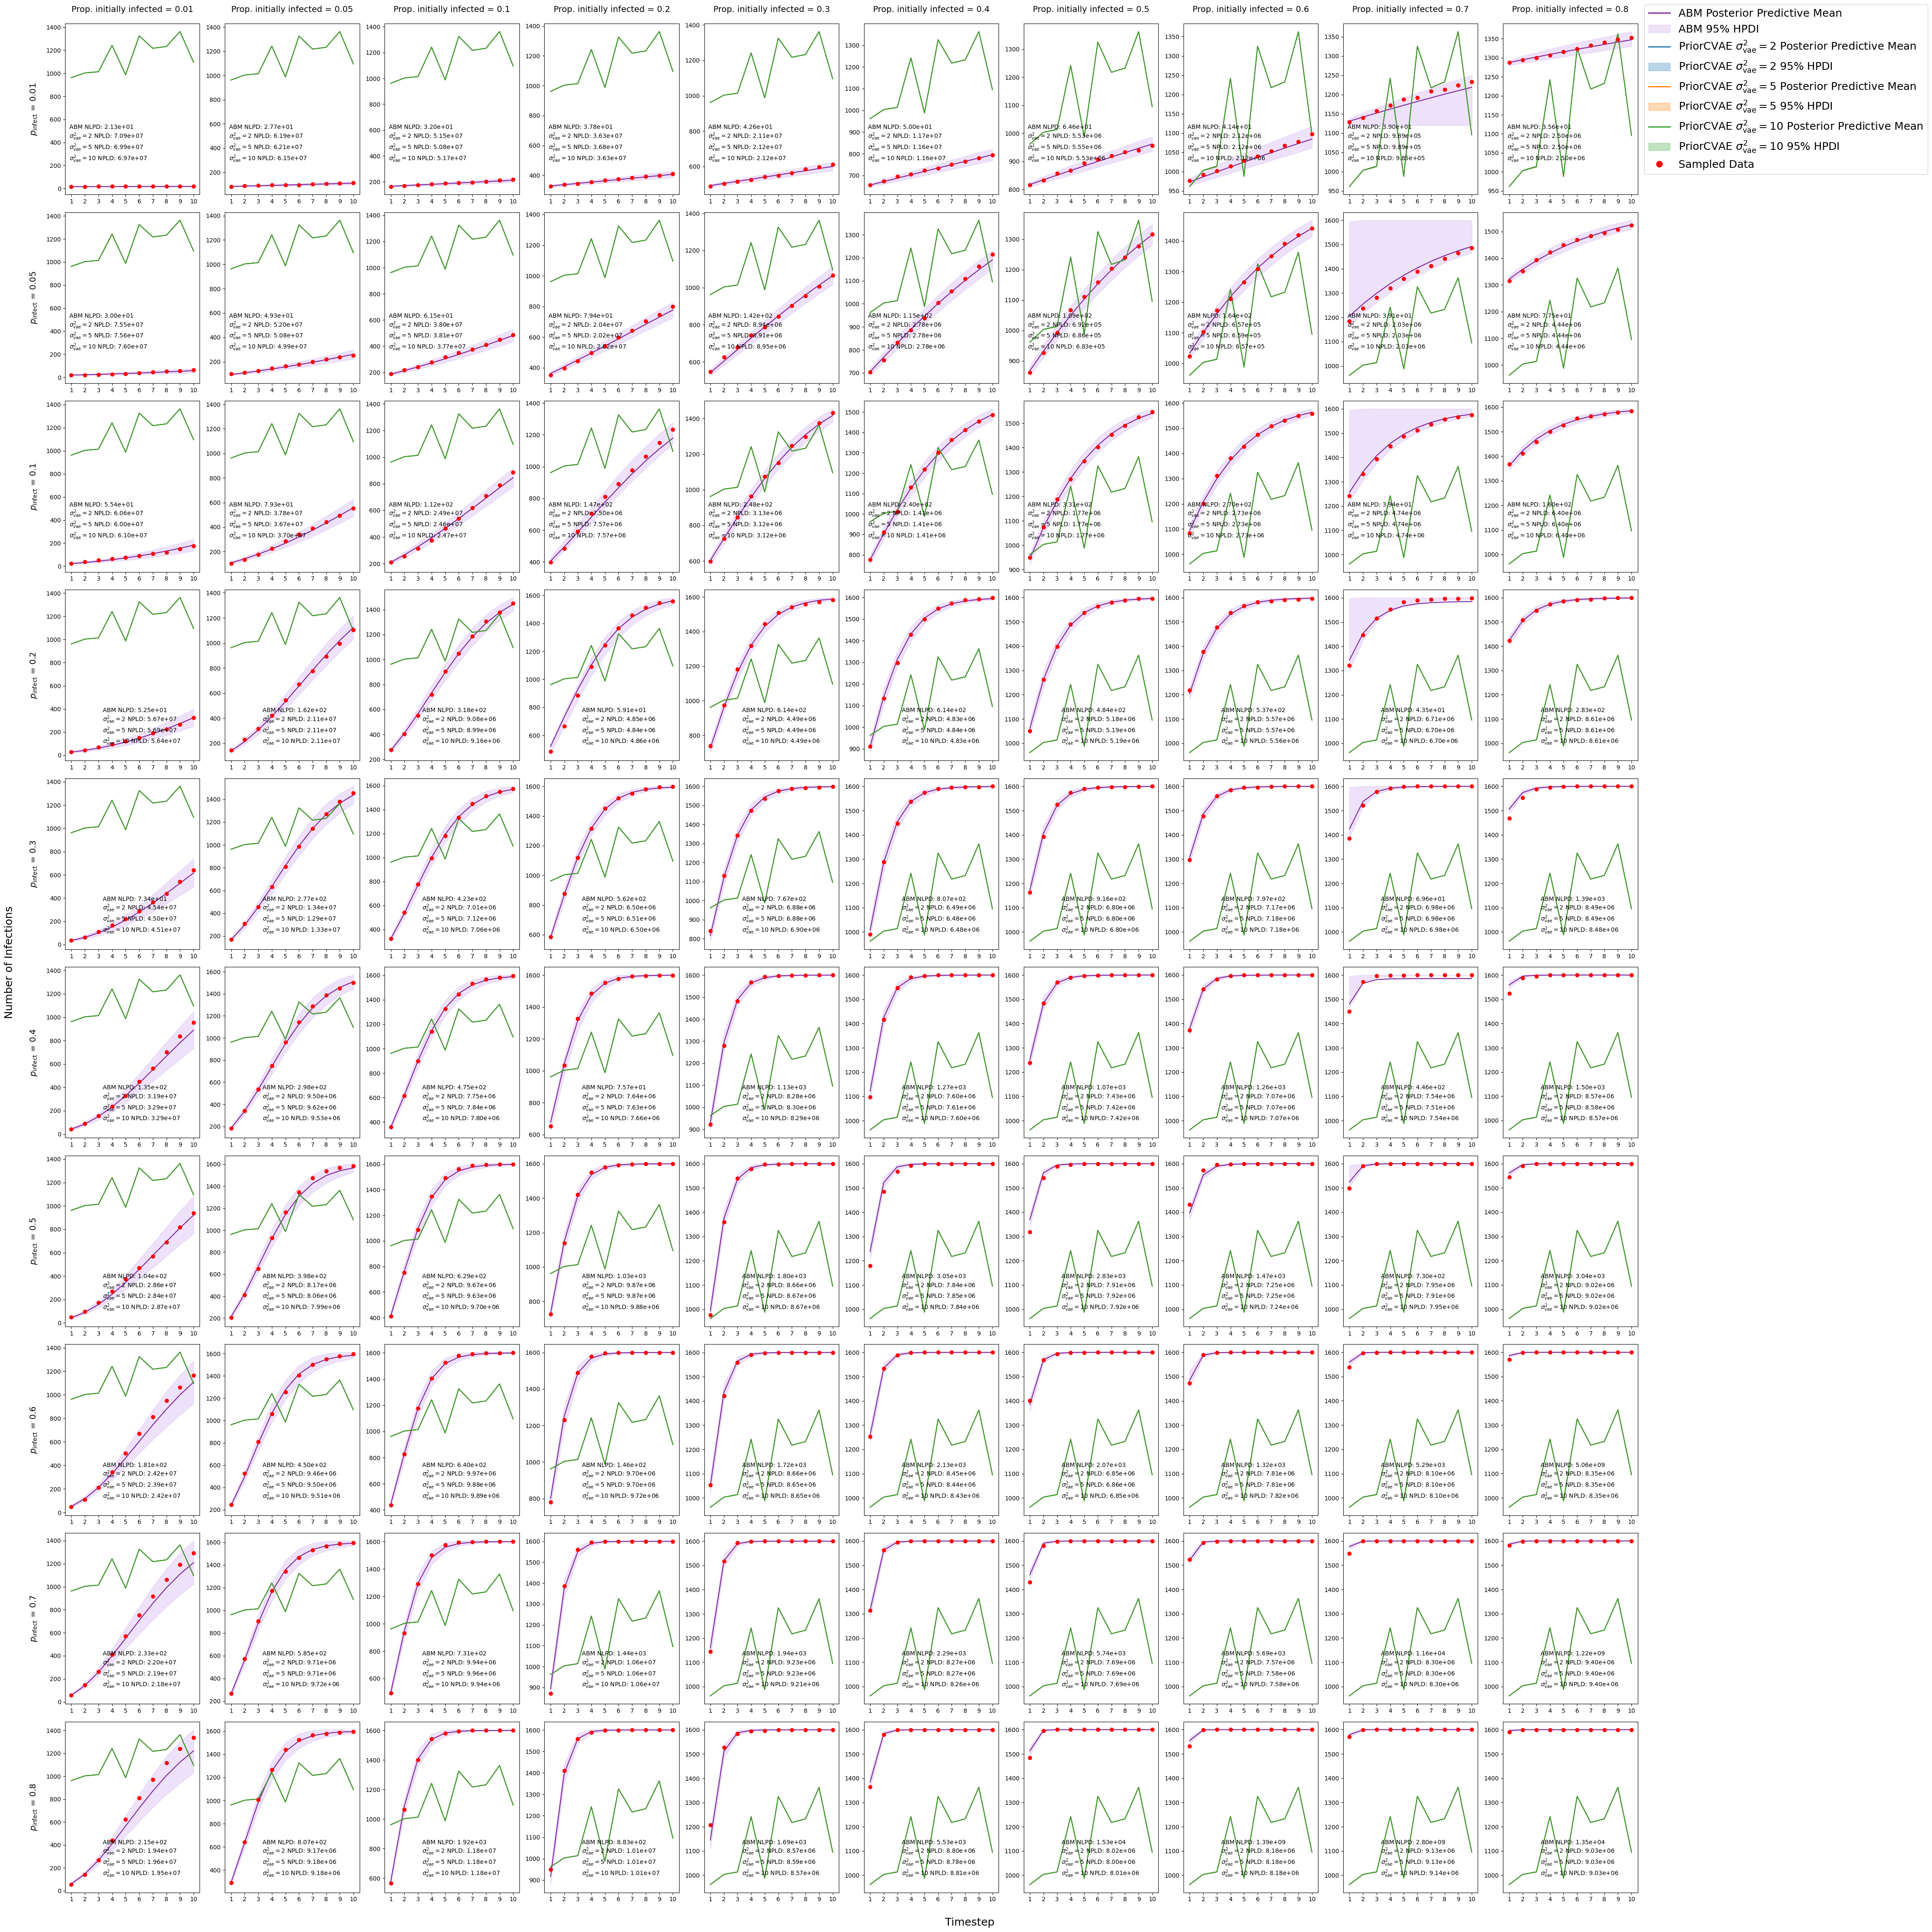

In [41]:
fig, axarr = plt.subplots(10,10,figsize=(45, 45))

nlpd_dict = {
    'abm':{k:v for k,v in zip(abm_posterior.keys(),priorcvae_var_metrics['NLPD']['abm'])},
    'priorcvae_vae_var_2': {k:v for k,v in zip(abm_posterior.keys(),priorcvae_var_metrics['NLPD']['priorcvae_vae_var_2'])},
    'priorcvae_vae_var_5': {k:v for k,v in zip(abm_posterior.keys(),priorcvae_var_metrics['NLPD']['priorcvae_vae_var_5'])},
    'priorcvae_vae_var_10': {k:v for k,v in zip(abm_posterior.keys(),priorcvae_var_metrics['NLPD']['priorcvae_vae_var_10'])},
}


for row,p_inf in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    for col,prop_init_infected in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
        axarr[row,col] =post_prediction_comparison(
            axarr[row,col],
            (p_inf,prop_init_infected),
            abm_posterior,
            surrogates_posterior,
            data,
            None, hpdi_alpha=0.3,
            show_legend=False,
            set_x_and_ylabels=False,
        ) 
        axarr[row,col].set_xticks(jnp.arange(0,10),jnp.arange(1,11))
        surrogate_nlpd_string = '\n'.join([f"{disp_name} NPLD: {nlpd_dict[surrogate_name][(p_inf,prop_init_infected)]:.2e}" for surrogate_name,disp_name in zip(['priorcvae_vae_var_2', 'priorcvae_vae_var_5', 'priorcvae_vae_var_10'], 
                                                                                                                                               ['$\sigma^{2}_{{\mathrm{{vae}}}}=2$', '$\sigma^{2}_{{\mathrm{{vae}}}}=5$', '$\sigma^{2}_{{\mathrm{{vae}}}}=10$'])])
        if row<=2:
            text_x=0.03
            text_y=0.2
        else:
            text_x=0.28
            text_y =0.1
        axarr[row,col].annotate(
            f"ABM NLPD: {nlpd_dict['abm'][(p_inf,prop_init_infected)]:.2e}\n"+surrogate_nlpd_string,
            (text_x,text_y),
            xycoords='axes fraction'
            )
        

legend_handles=[]
for idx,color in enumerate([get_color_by_label(axarr[0,0],'ABM Posterior Predictive Mean'), 
            get_color_by_label(axarr[0,0],'ABM 95% HPDI'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_2 Posterior Predictive Mean'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_2 95% HPDI'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_5 Posterior Predictive Mean'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_5 95% HPDI'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_10 Posterior Predictive Mean'),
            get_color_by_label(axarr[0,0],'priorcvae_vae_var_10 95% HPDI'),
            
            ]):
    
    if idx%2==0:
        legend_handle = Line2D([0],[0],color=color,
                           linestyle='-',linewidth=2)
    else:
        legend_handle=mpatches.Patch(color=color)
    legend_handles.append(legend_handle)
legend_handles.append(Line2D([],[],color='None', marker='o',linestyle='None',markersize=10,
                             markerfacecolor='red',markeredgecolor='red'))

for idx,p_infect in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    axarr[idx, 0].set_ylabel(f'$p_{{\mathrm{{infect}}}}$ = {p_infect}', rotation=90, labelpad=20, va='center',fontsize=14)

for jdx, initial_infected in enumerate([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    axarr[0,jdx].set_xlabel(f"Prop. initially infected = {initial_infected}",labelpad=20,fontsize=14)
    axarr[0, jdx].xaxis.set_label_position('top') 

fig.legend(handles=legend_handles, labels=['ABM Posterior Predictive Mean', 
                                           'ABM 95% HPDI', 
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=2$ Posterior Predictive Mean', 
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=2$ 95% HPDI',
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=5$ Posterior Predictive Mean', 
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=5$ 95% HPDI',
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=10$ Posterior Predictive Mean', 
                                           'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=10$ 95% HPDI',
                                           'Sampled Data'],
           loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure,fontsize=18)
fig.supylabel('Number of Infections',fontsize=18,x=-0.001)
fig.supxlabel('Timestep',fontsize=18,y=-0.001)
# # fig.suptitle('Comparison of ABM and surrogate posterior predictions across 100 combinations of prob_infect and initial_infected\nGrid Size 40 and Num Steps 10', 
# #              y=1.01,fontsize=20)
plt.tight_layout(rect=[0, 0, 0.85, 1],h_pad=1,w_pad=1)
fig.savefig('../06_02_viz/priorcvae_vae_vars_preds.pdf',bbox_inches='tight')
plt.show()

## Restart and run this section separately (Switch to cuda)

In [5]:
import os
from inference.spatial_compartmental.viz import  posterior_comparison, post_prediction_comparison
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from abm.spatial_compartmental.si import get_abm
from abm.spatial_compartmental.utils import Neighbourhood, calc_start_n_initial
from matplotlib.lines import Line2D
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from checkpointing import CheckPointer
import matplotlib.ticker as ticker
from functools import partial
from flax import nnx


In [2]:
print(f"JAX devices: {jax.devices()}")

JAX devices: [CudaDevice(id=0)]


In [6]:
def preds_plot(ax, I_list, colour,alpha):
    line_data = (jnp.mean(I_list, axis=0)
    )
    quantiles_I_2pt5 = jnp.quantile(I_list, 0.025, axis=0)
    quantiles_I_97pt5 = jnp.quantile(I_list, 0.975, axis=0)
    ax.plot(range(1,11), line_data, color=colour)
    ax.fill_between(
        range(1,11),
        quantiles_I_2pt5,
        quantiles_I_97pt5,
        color=colour,
        alpha=alpha,
    )

In [7]:
abm = get_abm(Neighbourhood.DIAGONAL,vmap=True)

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_54460/7135289.py:20: SyntaxWarning: invalid escape sequence '\m'
  axarr[idx].set_xlabel(f"$p_{{\mathrm{{infect}}}}$ = {p_inf} and Initial infection = {calc_start_n_initial(prop_initial, 10)}")
/tmp/ipykernel_54460/7135289.py:58: SyntaxWarning: invalid escape sequence '\s'
  legend_labels=['SI ABM', 'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=2$',
/tmp/ipykernel_54460/7135289.py:59: SyntaxWarning: invalid escape sequence '\s'
  'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=5$', 'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=10$']
/tmp/ipykernel_54460/7135289.py:59: SyntaxWarning: i

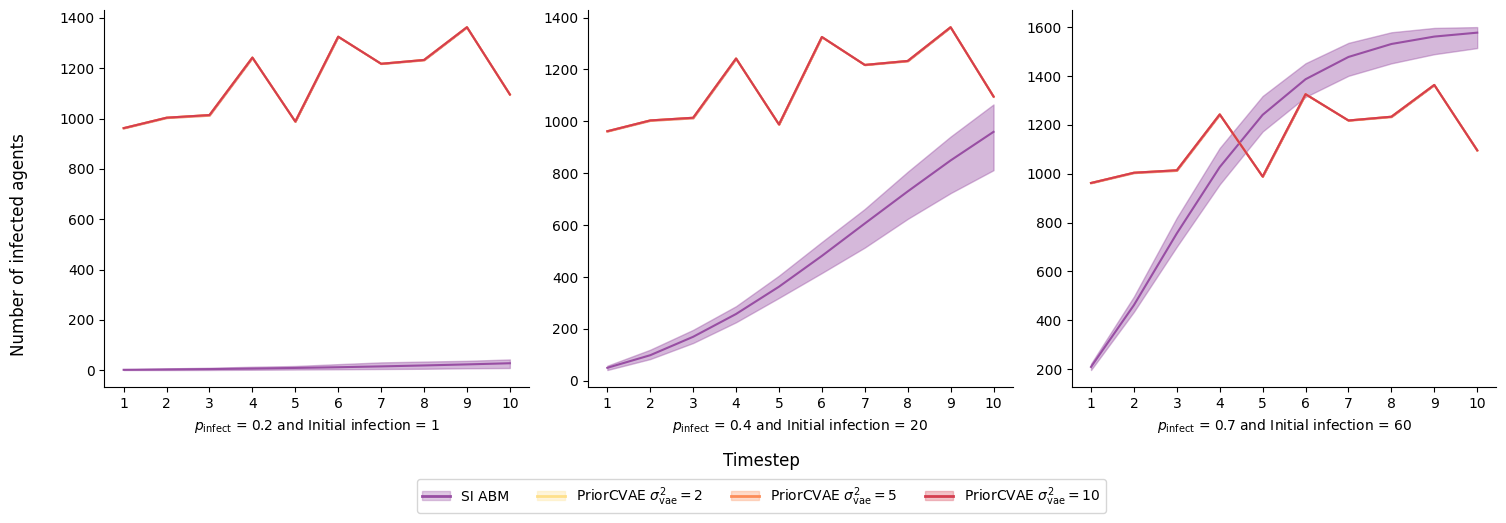

In [17]:
fig, axarr = plt.subplots(1,3, figsize=(15,5))

priorcvae_var2 = CheckPointer.load('trained_models/2025-06-01/17-38-23/')[0]
priorcvae_var5 = CheckPointer.load('trained_models/2025-06-01/17-39-14/')[0]
priorcvae_var10 = CheckPointer.load('trained_models/2025-06-01/17-40-05/')[0]

for idx, (p_inf, prop_initial) in enumerate(zip([0.2,0.4,0.7],[0.01,0.2,0.6])):
    axarr[idx].spines[["right", "top"]].set_visible(False)
    axarr[idx].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axarr[idx].set_xticks(range(1, int(10) + 1))
    _, _, abm_I_list = abm(
            jax.random.split(jax.random.key(42),50),
            40,
            10,
            p_inf,
            calc_start_n_initial(prop_initial, 10),
        )
    abm_I_list = abm_I_list[:,1:]
    preds_plot(axarr[idx], abm_I_list, '#984ea3',alpha=0.4)
    axarr[idx].set_xlabel(f"$p_{{\mathrm{{infect}}}}$ = {p_inf} and Initial infection = {calc_start_n_initial(prop_initial, 10)}")

    priorcvae_var2_I_list = priorcvae_var2.generate_decoder_samples(key=jax.random.key(42),   num_samples=50,
             c=jnp.broadcast_to(
             jnp.array([p_inf, prop_initial]),
                 (50, 2),
             ),)
    priorcvae_var2_I_list = priorcvae_var2_I_list[:,1:]*(40**2)
    preds_plot(axarr[idx], priorcvae_var2_I_list, '#fee08b', alpha=0.4)


    priorcvae_var5_I_list = priorcvae_var5.generate_decoder_samples(key=jax.random.key(42),   num_samples=50,
             c=jnp.broadcast_to(
             jnp.array([p_inf, prop_initial]),
                 (50, 2),
             ),)
    priorcvae_var5_I_list = priorcvae_var5_I_list[:,1:]*(40**2)
    preds_plot(axarr[idx], priorcvae_var5_I_list, '#fc8d59', alpha=0.4)


    priorcvae_var10_I_list = priorcvae_var10.generate_decoder_samples(key=jax.random.key(42),   num_samples=50,
             c=jnp.broadcast_to(
             jnp.array([p_inf, prop_initial]),
                 (50, 2),
             ),)
    priorcvae_var10_I_list = priorcvae_var10_I_list[:,1:]*(40**2)
    preds_plot(axarr[idx], priorcvae_var10_I_list, '#d53e4f', alpha=0.4)



    #mcmlp_I_list = mcmlp_I_list[:,1:]*(10**2)
    #preds_plot(axarr[idx], mcmlp_I_list, '#377eb8', alpha=0.4)
#del priorcvae
# del mcmlp

fig.supylabel('Number of infected agents',fontsize=12,x=-0.001)
fig.supxlabel('Timestep',fontsize=12,y=0.05)
legend_handles=[]
legend_labels=['SI ABM', 'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=2$',
               'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=5$', 'PriorCVAE $\sigma^{2}_{{\mathrm{{vae}}}}=10$']
for colour in ['#984ea3','#fee08b', '#fc8d59', '#d53e4f']:
    legend_handles.append((Line2D([0],[0],color=colour,
                           linestyle='-', linewidth=2),mpatches.Patch(color=colour,alpha=0.3)))
fig.legend(handles=legend_handles, labels=legend_labels,loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(legend_labels))

plt.tight_layout(rect=[0, 0.025, 1, 1],h_pad=1,w_pad=1)
fig.savefig('../06_02_viz/priorcvae_vae_var_g40s10_realisation_stoch.pdf',bbox_inches='tight')
